In [2]:
!pip install xgboost

  Using cached xgboost-3.0.2-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

#Load and Filter Dataset
df = pd.read_csv("Project/reddit_labeled.csv")
df = df[df["label"].isin([
    "neutral", "academic_stress", "relationship_issues",
    "existential_crisis", "social_isolation"
])]

#Encode String Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["label"])  # convert to 0..4

#Train/Test Split
X = df["clean_text"].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

#TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

#Train XGBoost Classifier
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train_vec, y_train)

#Predictions
y_pred = xgb_clf.predict(X_test_vec)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

#Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels, digits=4))

#Accuracy
acc = accuracy_score(y_test_labels, y_pred_labels)
print(f" Overall Accuracy: {acc:.4f}")

/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:26:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Classification Report:

                     precision    recall  f1-score   support

    academic_stress     0.9980    0.9469    0.9718       527
 existential_crisis     0.7500    0.5000    0.6000        18
            neutral     0.7949    0.9125    0.8497       480
relationship_issues     0.8605    0.8004    0.8294       501
   social_isolation     0.5556    0.4167    0.4762        12

           accuracy                         0.8791      1538
          macro avg     0.7918    0.7153    0.7454      1538
       weighted avg     0.8835    0.8791    0.8791      1538

 Overall Accuracy: 0.8791


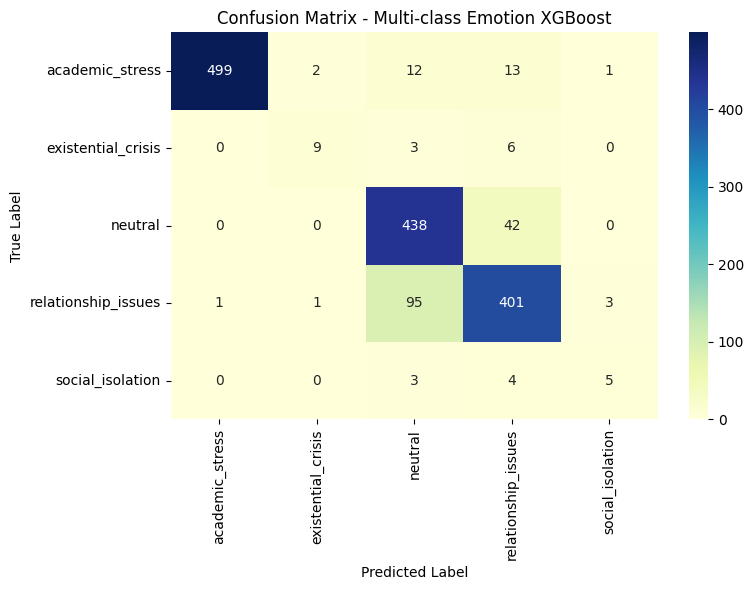

XGBoost Model + Vectorizer + LabelEncoder saved to: Project/Models/XGboost_Multiclass/


In [4]:
#Confusion Matrix
classes = label_encoder.classes_
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Multi-class Emotion XGBoost")
plt.tight_layout()
plt.show()

#Save Model, Vectorizer, and Encoder
os.makedirs("Project/Models/XGboost_Multiclass", exist_ok=True)
joblib.dump(xgb_clf, "Project/Models/XGboost_Multiclass/emotion_xgb_classifier.joblib")
joblib.dump(tfidf,   "Project/Models/XGboost_Multiclass/tfidf_vectorizer.joblib")
joblib.dump(label_encoder, "Project/Models/XGboost_Multiclass/label_encoder.joblib")

print("XGBoost Model + Vectorizer + LabelEncoder saved to: Project/Models/XGboost_Multiclass/")

In [7]:
#Imports
import joblib

#Load XGBoost Model and Vectorizer
xgb = joblib.load("Project/Models/XGboost_Multiclass/emotion_xgb_classifier.joblib")
tfidf = joblib.load("Project/Models/XGboost_Multiclass/tfidf_vectorizer.joblib")
label_encoder = joblib.load("Project/Models/XGboost_Multiclass/label_encoder.joblib")

#Map Labels to Severity
INTENSITY_LEVELS = {
    "neutral": 0.00,
    "social_isolation": 0.25,
    "relationship_issues": 0.50,
    "academic_stress": 0.75,
    "existential_crisis": 1.00
}

#Predict Function
def predict_emotion_with_intensity(text):
    vec = tfidf.transform([text])
    pred_encoded = xgb.predict(vec)[0]
    pred_label = label_encoder.inverse_transform([pred_encoded])[0]
    intensity = INTENSITY_LEVELS.get(pred_label, -1)
    return pred_label, intensity

#Example
sample = "I hate my life"
label, score = predict_emotion_with_intensity(sample)

print(f"Predicted Emotion: {label}")
print(f"Severity Level: {score}")

Predicted Emotion: neutral
Severity Level: 0.0
